Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt

%matplotlib inline 

First reload the data we generated in _notmist.ipynb_.

In [34]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [35]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [36]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [37]:
#Problem 1.A. L2 Regularization in the Logistic Model

In [38]:
batch_size = 128

graph = tf.Graph()
    
with graph.as_default():

    # Input data. 
    # For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_l2_beta = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    #You modify here...
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)+
    (tf_l2_beta*tf.nn.l2_loss(weights)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [39]:
num_steps = 3001

l2_betas = np.logspace(-7, -1, 10)
valid_accuracy = []
test_accuracy = []

for l2_beta in l2_betas:   
    
    print("Training for l2_beta: " + str(l2_beta) + "...")
    with tf.Session(graph=graph) as session:

        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                         tf_l2_beta : l2_beta}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
#             if (step % 500 == 0):
#                 print("Minibatch loss at step %d: %f" % (step, l))
#                 print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#                 print("Validation accuracy: %.1f%%" % accuracy(
#                         valid_prediction.eval(), valid_labels))
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
        
    #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Training for l2_beta: 1e-07...
Initialized
Training for l2_beta: 4.64158883361e-07...
Initialized
Training for l2_beta: 2.15443469003e-06...
Initialized
Training for l2_beta: 1e-05...
Initialized
Training for l2_beta: 4.64158883361e-05...
Initialized
Training for l2_beta: 0.000215443469003...
Initialized
Training for l2_beta: 0.001...
Initialized
Training for l2_beta: 0.00464158883361...
Initialized
Training for l2_beta: 0.0215443469003...
Initialized
Training for l2_beta: 0.1...
Initialized


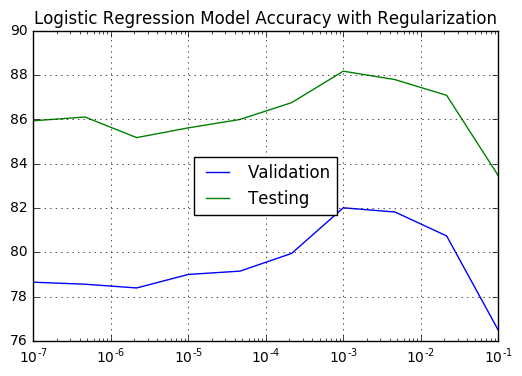

In [40]:
plt.semilogx(l2_betas, valid_accuracy)
plt.hold
plt.semilogx(l2_betas, test_accuracy)
plt.grid(True)
plt.title('Logistic Regression Model Accuracy with Regularization')
plt.legend(['Validation', 'Testing'], loc='center')
plt.show()

In [41]:
#Problem 1.B. L2 Regularization in the Neural Model with 1 Hidden Layer

In [53]:
batch_size = 128
hidden_units = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. 
    # For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_l2_beta = tf.placeholder(tf.float32)

    # Variables.
    # 1. Weights and biases for the input data
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]))
    biases1 = tf.Variable(tf.zeros([hidden_units]))
    # 2. Weights and biases for the hidden layer
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    #Modify here (Biases not penalized)...
    unregularized_loss = tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    l2_loss = l2_beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    loss = tf.reduce_mean(tf.add(unregularized_loss, l2_loss, name='loss'))

    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_logits = tf.matmul(valid_hidden, weights2) + biases2
    valid_prediction = tf.nn.softmax(valid_logits)

    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_logits = tf.matmul(test_hidden, weights2) + biases2
    test_prediction = tf.nn.softmax(test_logits)

In [54]:
num_steps = 5001

l2_betas = np.logspace(-2, 2, 5)
valid_accuracy = []
test_accuracy = []

for l2_beta in l2_betas:   
    
    print("Training for l2_beta: " + str(l2_beta) + "...")
    with tf.Session(graph=graph) as session:

        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                         tf_l2_beta : l2_beta}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
#             if (step % 500 == 0):
#                 print("Minibatch loss at step %d: %f" % (step, l))
#                 print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#                 print("Validation accuracy: %.1f%%" % accuracy(
#                         valid_prediction.eval(), valid_labels))
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
        print("Done.")
        
    #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Training for l2_beta: 0.01...
Initialized
Done.
Training for l2_beta: 0.1...
Initialized
Done.
Training for l2_beta: 1.0...
Initialized
Done.
Training for l2_beta: 10.0...
Initialized
Done.
Training for l2_beta: 100.0...
Initialized
Done.


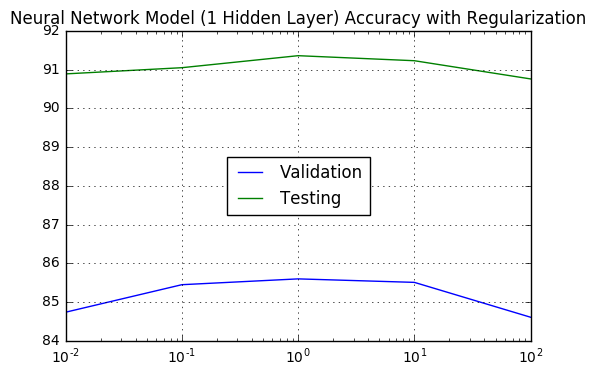

In [55]:
plt.semilogx(l2_betas, valid_accuracy)
plt.hold
plt.semilogx(l2_betas, test_accuracy)
plt.grid(True)
plt.title('Neural Network Model (1 Hidden Layer) Accuracy with Regularization')
plt.legend(['Validation', 'Testing'], loc='center')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Extreme case of overfitting accurs when a complex model is trained on small amount of data with no regularization terms. This can be shown in the following model.

In [61]:
batch_size = 128
hidden_units = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. 
    # For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # 1. Weights and biases for the input data
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]))
    biases1 = tf.Variable(tf.zeros([hidden_units]))
    # 2. Weights and biases for the hidden layer
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_logits = tf.matmul(valid_hidden, weights2) + biases2
    valid_prediction = tf.nn.softmax(valid_logits)

    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_logits = tf.matmul(test_hidden, weights2) + biases2
    test_prediction = tf.nn.softmax(test_logits)

In [62]:
num_steps = 1001
num_batches = 5 #For restricting the training data.

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = ((step % num_batches)* batch_size)
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                    valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 320.951965
Minibatch accuracy: 7.8%
Validation accuracy: 30.9%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Test accuracy: 82.2%


We can see in the above results, the training accuracy is perfect while the validation is low. So, there is definitely overfitting in this case.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [67]:
batch_size = 128
hidden_units = 1024
dropout = 0.5

graph = tf.Graph()
with graph.as_default():

    # Input data. 
    # For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    # For Dropout...
    keep_prob = tf.placeholder(tf.float32)
    
    # Variables.
    # 1. Weights and biases for the input data
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]))
    biases1 = tf.Variable(tf.zeros([hidden_units]))
    # 2. Weights and biases for the hidden layer
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    
    # Training computation.
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    #For Dropout...
    hidden_drop = tf.nn.dropout(hidden, keep_prob)
    logits = tf.matmul(hidden_drop, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_logits = tf.matmul(valid_hidden, weights2) + biases2
    valid_prediction = tf.nn.softmax(valid_logits)

    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_logits = tf.matmul(test_hidden, weights2) + biases2
    test_prediction = tf.nn.softmax(test_logits)

In [68]:
num_steps = 5001

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                    keep_prob : dropout}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                    valid_prediction.eval(feed_dict = {keep_prob : 1.0}), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
            test_prediction.eval(feed_dict = {keep_prob : 1.0}), test_labels))

Initialized
Minibatch loss at step 0: 504.049744
Minibatch accuracy: 11.7%
Validation accuracy: 28.1%
Minibatch loss at step 500: 27.957483
Minibatch accuracy: 80.5%
Validation accuracy: 80.9%
Minibatch loss at step 1000: 22.151793
Minibatch accuracy: 68.8%
Validation accuracy: 80.1%
Minibatch loss at step 1500: 5.887916
Minibatch accuracy: 70.3%
Validation accuracy: 79.5%
Minibatch loss at step 2000: 22.633575
Minibatch accuracy: 77.3%
Validation accuracy: 79.5%
Minibatch loss at step 2500: 11.749903
Minibatch accuracy: 71.9%
Validation accuracy: 78.7%
Minibatch loss at step 3000: 3.137950
Minibatch accuracy: 79.7%
Validation accuracy: 80.1%
Minibatch loss at step 3500: 2.837876
Minibatch accuracy: 77.3%
Validation accuracy: 80.3%
Minibatch loss at step 4000: 5.553745
Minibatch accuracy: 74.2%
Validation accuracy: 80.2%
Minibatch loss at step 4500: 2.612624
Minibatch accuracy: 75.8%
Validation accuracy: 80.6%
Minibatch loss at step 5000: 1.771448
Minibatch accuracy: 77.3%
Validation a

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 ---

*Solution*

***Note:*** Codes refactored based on the github code [here](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb).

And tensorflow examples are given [here](https://github.com/aymericdamien/TensorFlow-Examples).

In [66]:
# # Import MINST data
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# import tensorflow as tf

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [87]:
# Parameters
learning_rate = 0.001
#training_epochs = 100
batch_size = 100
display_step = 5

# Network Parameters
n_hidden_1 = 512 # 1st layer number of features
n_hidden_2 = 512 # 2nd layer number of features
n_hidden_3 = 512 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [88]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
    return out_layer

In [89]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

#Evaluate the model (and calculate accuracy)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))*100.0

In [90]:
num_steps = 20001

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {x : batch_data, y : batch_labels}
        _, l = sess.run([optimizer, cost], feed_dict=feed_dict)

#         _, l, predictions = sess.run(
#           [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy.eval(feed_dict = feed_dict))
            feed_dict = {x : valid_dataset, y : valid_labels}
            print("Validation accuracy: %.1f%%" % accuracy.eval(feed_dict = feed_dict))

    feed_dict = {x : test_dataset, y : test_labels}
    print("Test accuracy: %.1f%%" % accuracy.eval(feed_dict = feed_dict))

Initialized
Minibatch loss at step 0: 89199.281250
Minibatch accuracy: 14.0%
Validation accuracy: 11.5%
Minibatch loss at step 500: 5378.951172
Minibatch accuracy: 75.0%
Validation accuracy: 76.3%
Minibatch loss at step 1000: 2237.180664
Minibatch accuracy: 87.0%
Validation accuracy: 78.9%
Minibatch loss at step 1500: 2526.059326
Minibatch accuracy: 77.0%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 1675.126709
Minibatch accuracy: 89.0%
Validation accuracy: 80.4%
Minibatch loss at step 2500: 1387.271606
Minibatch accuracy: 83.0%
Validation accuracy: 80.7%
Minibatch loss at step 3000: 1190.238159
Minibatch accuracy: 85.0%
Validation accuracy: 81.1%
Minibatch loss at step 3500: 1018.719543
Minibatch accuracy: 82.0%
Validation accuracy: 81.4%
Minibatch loss at step 4000: 590.024902
Minibatch accuracy: 86.0%
Validation accuracy: 81.7%
Minibatch loss at step 4500: 671.138977
Minibatch accuracy: 87.0%
Validation accuracy: 81.4%
Minibatch loss at step 5000: 839.578308
Minibatch acc

In [ ]:
    # Training cycle
#     for epoch in range(training_epochs):
#         avg_cost = 0.

#         total_batch = int(mnist.train.num_examples/batch_size)
#         # Loop over all batches
#         for i in range(total_batch):
#             batch_x, batch_y = mnist.train.next_batch(batch_size)
#             # Run optimization op (backprop) and cost op (to get loss value)
#             _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
#                                                           y: batch_y})
#             # Compute average loss
#             avg_cost += c / total_batch
#         # Display logs per epoch step
#         if epoch % display_step == 0:
#             print("Epoch: " + str(epoch) + ", cost=" + "{:.9f}".format(avg_cost))
#     print("Optimization Finished!")

    # Test model
    #correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #print("Testing Accuracy:" + str(accuracy.eval({x: mnist.test.images, y: mnist.test.labels})))